In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from dotenv import load_dotenv
from datetime import datetime
import os
import tarfile
import io
import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show

In [2]:
load_dotenv()

client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"

In [3]:
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

In [4]:
gdf = gpd.read_file('train/pac_2024_training.shp')

In [5]:
grouped = gdf.groupby('yr')

In [6]:
def generate_time_range(year):
    previous_year = year - 1
    next_year = year + 1

    start_date = f"{previous_year}-06-01T00:00:00Z"
    end_date = f"{next_year}-06-01T00:00:00Z"

    return start_date, end_date

In [7]:
def download_data(bounds, year):
    evalscript = """
    //VERSION=3
    function setup() {
    return {
        input: [
        {
            bands: ["B04", "B03", "B02"],
            units: "REFLECTANCE", // default units
        },
        ],
        output: [
        {
            id: "default",
            bands: 3,
            sampleType: "AUTO", // default  - scales the output values from input values [0,1] to [0,255].
        }
        //{
        //    id: "true_color_16bit",
        //    bands: 3,
        //    sampleType: "UINT16", //floating point values are automatically rounded to the nearest integer by the service.
        //},
        ],
    }
    }

    function evaluatePixel(sample) {
    return {
        // output band values are scaled from [0,1] to [0,255]. Multiply by 2.5 to increase brightness
        default: [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02],

        // Multiply input reflectance values by 2.5 to increase brightness and by 65535 to return the band values clamped to [0, 65535] unsigned 16 bit range.
        // true_color_16bit: [
        // 2.5 * sample.B04 * 65535,
        // 2.5 * sample.B03 * 65535,
        // 2.5 * sample.B02 * 65535,
        // ]
    }
    }
    """

    start_date, end_date = generate_time_range(year)

    request = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
                "bbox": [
                    bounds[0],
                    bounds[1],
                    bounds[2],
                    bounds[3],
                ],
            },
            "data": [
                {
                    "type": "sentinel-2-l1c",
                    "dataFilter": {
                        "timeRange": {
                            "from": start_date,
                            "to": end_date,
                        },
                        "maxCloudCoverage": 20,
                    },
                }
            ],
        },
        "output": {    
            "width": 1024,
            "height": 1024,
            "responses": [
                # {
                #     "identifier": "default",
                #     "format": {"type": "image/jpeg"},
                # },
                {
                    "identifier": "default",
                    "format": {"type": "image/tiff"},
                },
            ],
        },
        "evalscript": evalscript,
    }

    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    return oauth.post(url, json=request, headers={"Accept": "application/tar"})

In [8]:
for name, group in grouped:
    for idx, row in group.iterrows():
        bounds = row['geometry'].bounds
        
        response = download_data(bounds, name)

        if response.status_code == 200:
            break
        else:
            print(response.json())
        
        break
    break

Opened default.tif with rasterio.
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1024, 'height': 1024, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.435106928489917e-07, 0.0, -69.14224792429687,
       0.0, -8.648338029354496e-06, -13.685654549844925), 'blockysize': 8, 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


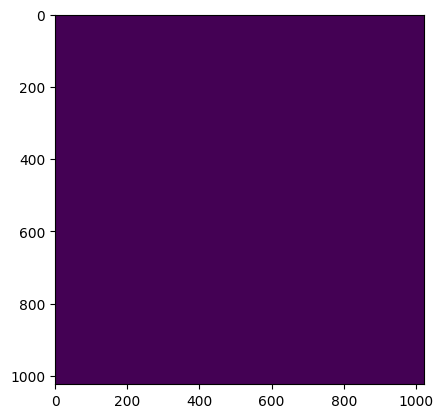

In [9]:
try:
    # Step 3: Open the TAR file from the in-memory bytes
    tar_bytes = io.BytesIO(response.content)
    
    with tarfile.open(fileobj=tar_bytes) as tar:
        # Step 4: Get the first (and only) file in the TAR archive
        member = tar.getmembers()[0]
        
        # Ensure the file is a .tif
        if member.name.endswith('.tif'):
            # Step 5: Extract the .tif file content into memory
            tif_file = tar.extractfile(member)
            
            if tif_file:
                # Step 6: Use rasterio to open the .tif file directly from memory
                with MemoryFile(tif_file.read()) as memfile:
                    with memfile.open() as dataset:
                        print(f"Opened {member.name} with rasterio.")
                        # Perform operations with rasterio
                        print(dataset.profile)  # Example: print the profile of the .tif file
                        # Example: read the first band of the raster
                        band1 = dataset.read(1)
                        print(band1)
                        show(band1)
                
except tarfile.TarError as e:
    print(f"Error extracting TAR file: {e}")